In [1]:
import sys, os
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.parquet as pq

%load_ext autoreload
%autoreload 2

In [2]:
# data_dir = "../data/ZTFBTS/"  # If unzipped locally
data_dir = "/ocean/projects/phy230064p/shared/kepseismic/BG_Data" # If running on Bridges

In [14]:
from astropy.io import fits
import pandas as pd

dir_light_curves = f"{data_dir}/"

def open_light_curve_fits(filename):
    """ Helper function to open a light curve csv file.
    """
    file_path = os.path.join(dir_light_curves, filename)
    with fits.open(file_path) as data_psd:
        df = pd.DataFrame(data_psd[1].data)
    return df

n_max_obs = 1000

# Open all light curves and save as list. Pad observations with zeros up to n_max_obs.
mag = np.zeros((len(os.listdir(dir_light_curves)), n_max_obs))
time = np.zeros((len(os.listdir(dir_light_curves)), n_max_obs))
mask = np.zeros((len(os.listdir(dir_light_curves)), n_max_obs), dtype=bool)

idx = 0
for filename in os.listdir(dir_light_curves):
    if filename.endswith(".fits"):
        df = open_light_curve_fits(filename)
        # If less than n_max_obs observations, pad with zeros
        if len(df.iloc[:,0].values) < n_max_obs:
            mag[idx, :len(df.iloc[:,0].values)] = df.iloc[:,1].values
            time[idx, :len(df.iloc[:,0].values)] = df.iloc[:,0].values
            mask[idx, :len(df.iloc[:,0].values)] = 1
        # Otherwise, randomly select n_max_obs observations
        else:
            rand_idx = np.random.choice(len(df.iloc[:,0].values), n_max_obs, replace=False)
            mag[idx, :] = df.iloc[:,1].values[rand_idx]
            time[idx, :] = df.iloc[:,0].values[rand_idx]
            mask[idx, :] = 1
        idx += 1

In [15]:
import math

import torch
import torch.nn as nn
import pytorch_lightning as pl

from models.transformer_utils import Transformer

In [16]:
# # Transformer from torch.nn
# encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
# transformer = nn.TransformerEncoder(encoder_layer, num_layers=6,)

# Our transformer from models/transformer_utiles.py
transformer = Transformer(emb=128, heads=2, depth=2, ff_hidden_mult=4)  # Instantiate

# Dummy inputs
mask_test = torch.ones((1, 100), dtype=torch.bool)
x = torch.randn((1, 100, 128))

# Forward pass
transformer(x, mask_test)

tensor([[[ 1.1121,  0.8055,  0.5262,  ...,  1.2332, -1.4972,  0.4320],
         [ 1.8725,  0.2912,  1.1283,  ...,  0.1330, -0.8512, -1.6398],
         [ 0.0586,  0.4806,  0.0308,  ..., -1.3632,  0.5167, -0.4511],
         ...,
         [-0.1214, -0.3452,  0.5496,  ..., -0.2248, -1.2256,  1.2711],
         [ 0.3644,  1.1173,  1.9463,  ...,  1.0722,  0.2955, -0.6599],
         [ 0.4382,  1.1305, -0.2090,  ...,  0.5223, -0.6597, -1.6678]]],
       grad_fn=<NativeLayerNormBackward0>)

In [17]:
class TimePositionalEncoding(nn.Module):
    """ Time encodings for Transformer. 
    """

    def __init__(self, d_emb):
        """
        Inputs
            d_emb - Dimensionality when projecting to the fourier feature basis.
        """
        super().__init__()
        self.d_emb = d_emb

    def forward(self, t):
        pe = torch.zeros(t.shape[0], t.shape[1], self.d_emb).to(t.device)  # (B, T, D)
        div_term = torch.exp(torch.arange(0, self.d_emb, 2).float() * (-math.log(10000.0) / self.d_emb))[None, None, :].to(t.device)  # (1, 1, D / 2)
        t = t.unsqueeze(2)  # (B, 1, T)
        pe[:, :, 0::2] = torch.sin(t * div_term)  # (B, T, D / 2)
        pe[:, :, 1::2] = torch.cos(t * div_term)  # (B, T, D / 2)
        return pe  # (B, T, D)

class TransformerWithTimeEmbeddings(nn.Module):
    """ Transformer encoer.
    """

    def __init__(self, n_out=1, **kwargs):
        """
        :param n_out: Number of outputs per sequence element (e.g., number of bands).
        :param kwargs: Transformer arguments.
        """
        super().__init__()
        
        self.embedding_mag = nn.Linear(in_features=1, out_features=kwargs['emb'])
        self.embedding_t = TimePositionalEncoding(kwargs['emb'])
        self.transformer = Transformer(**kwargs)
        self.projection = nn.Linear(in_features=kwargs['emb'], out_features=n_out)

    def forward(self, x, t, mask=None):
        """
        :param x: Input sequence (B, T, 1).
        :param t: Time sequence (B, T).
        :param mask: Padding mask (B, T).
        :return: Output sequence (B, T, n_out).
        """
        t = t - t[:, 0].unsqueeze(1)  # (B, T)  # Relative time
        t_emb = self.embedding_t(t)  # (B, T, D)  # Project to embedding dimension of transformer
        x = self.embedding_mag(x) + t_emb  # (B, T, D)  # Add time embeddings to magnitude embeddings
        x = self.transformer(x, mask)  # (B, T, D)  # Transformer
        x = self.projection(x)  # (B, T, n_out)  # Project each sequence element (independently) to output dim

        return x

transformer = TransformerWithTimeEmbeddings(n_out=1, emb=128, heads=2, depth=2)

In [18]:
# Convert to torch tensors
mag = torch.Tensor(mag)
time = torch.Tensor(time)
mask = torch.Tensor(mask).to(torch.bool)

# Standardize mag
mag_mean = mag.mean()
mag_std = mag.std()
mag = (mag - mag_mean) / mag_std

# # Standardize time # Don't standardize time, since we'll zero-subtract for simplicity
# time_mean = time.mean()
# time_std = time.std()
# time = (time - time_mean) / time_std

In [19]:
# Convenience function to get random masks

def get_random_mask(padding_mask, f_mask=0.15):
    """ Get a random contiguous masks for the input sequence.
    :param padding_mask: Padding mask (B, T).
    :param f_mask: Fraction of mask to keep.
    :return: Mask (B, T).
    """
    mask = torch.ones_like(padding_mask)
    mask_pred = torch.ones_like(padding_mask)
    for i in range(padding_mask.shape[0]):
        n_obs = padding_mask[i].sum().item()
        n_obs_to_keep = int(n_obs * f_mask)
        start = torch.randint(0, n_obs - n_obs_to_keep + 1, (1,)).item()
        end = start + n_obs_to_keep

        # Mask containing observations to be kept
        mask[i, start:end] = False  # Mask out observations from start to end
        mask[i, n_obs:] = False

        # Mask only containing observations to be predicted
        mask_pred[i, end:n_obs] = False
        mask_pred[i, :start] = False
        mask_pred[i, start:end] = True
        mask_pred[i, n_obs:] = False
        
    return mask, mask_pred

# Test the mask function

f_mask = 0.15
mask_test = mask[144:]
mask_in, mask_pred = get_random_mask(mask_test, f_mask=f_mask)  # Mask out 15% of observations

Mask


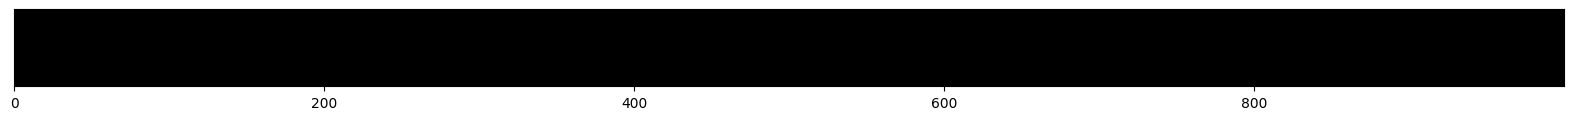

Mask in: original mask with 0.15 of observations masked out


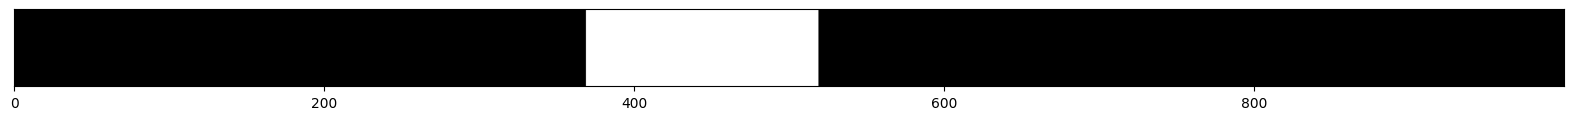

Mask pred: observations to be predicted


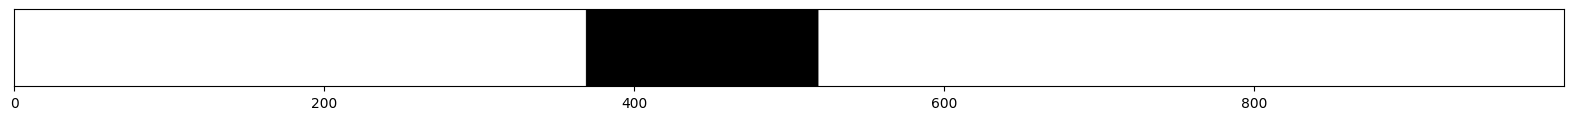

In [20]:
# Function to plot a mask
def plot_mask(mask):
    """ `mask` is a 1D boolean array.
    """
    plt.figure(figsize=(20, 1))
    plt.imshow(mask[None, :], aspect='auto', cmap='binary', vmin=0, vmax=1)
    plt.yticks([])
    plt.show()

print("Mask")
plot_mask(mask_test[0].detach().numpy())

print(f"Mask in: original mask with {f_mask} of observations masked out")
plot_mask(mask_in[0].detach().numpy())

print("Mask pred: observations to be predicted")
plot_mask(mask_pred[0].detach().numpy())

In [21]:
n_small_batch = 4

out = transformer(mag[:n_small_batch].unsqueeze(-1), time[:n_small_batch], mask[:n_small_batch])  # Unsqueeze just adds a channel dimension (B, T, 1)
out.shape

torch.Size([4, 1000, 1])

In [22]:
class MaskedLightCurveEncoder(pl.LightningModule):
    def __init__(self, f_mask=0.2, transformer_kwargs={"n_out":1, "emb":128, "heads":2, "depth":4}, optimizer_kwargs={}, lr=1e-3):
        super().__init__()

        self.optimizer_kwargs = optimizer_kwargs
        self.lr = lr
        self.f_mask = f_mask

        self.net = TransformerWithTimeEmbeddings(**transformer_kwargs)

    def forward(self, x, t, mask=None):
        x = x[..., None]
        x = self.net(x, t, mask)
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.RAdam(self.parameters(), lr=self.lr, **self.optimizer_kwargs)
        return {"optimizer": optimizer}

    def masked_pred(self, x, t, padding_mask, f_mask=0.15):
        # Get random mask and predict with masked inputs; then, return only the unmasked outputs
        mask_in, mask_pred = get_random_mask(padding_mask, f_mask=f_mask)
        x_masked = x.clone()
        x_masked[~mask_in] = 0
        x_pred = self(x_masked, t, mask=padding_mask)[..., 0]  
        return x[mask_pred], x_pred[mask_pred]
    
    def training_step(self, batch, batch_idx):
        x, t, padding_mask = batch
        x, x_pred = self.masked_pred(x, t, padding_mask, f_mask=self.f_mask)
        loss = nn.MSELoss()(x, x_pred)
        self.log("train_loss", loss, on_epoch=True, on_step=False, prog_bar=True,)
        return loss

    def validation_step(self, batch, batch_idx):
        x, t, padding_mask = batch
        x, x_pred = self.masked_pred(x, t, padding_mask, f_mask=self.f_mask)
        loss = nn.MSELoss()(x, x_pred)
        self.log("val_loss", loss, on_epoch=True, on_step=False, prog_bar=True,)
        return loss

In [23]:
mlce = MaskedLightCurveEncoder(f_mask=0.15, lr=6e-4, transformer_kwargs={"n_out":1, "emb":256, "heads":4, "depth":12, "dropout":0.02})

In [24]:
from torch.utils.data import TensorDataset, DataLoader, random_split

val_fraction = 0.05
batch_size = 64
n_samples_val = int(val_fraction * mag.shape[0])

dataset = TensorDataset(mag, time, mask)

dataset_train, dataset_val = random_split(dataset, [mag.shape[0] - n_samples_val, n_samples_val])
train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
trainer = pl.Trainer(max_epochs=100, accelerator='gpu',)
trainer.fit(model=mlce, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/jet/home/schen15/.local/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /jet/home/schen15/lightning_logs/version_21769829/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                          | Params
-------------------------------------------------------
0 | net  | TransformerWithTimeEmbeddings | 9.5 M 
-------------------------------------------------------
9.5 M     Trainable params
0         Non-trainable params
9.5 M     Total params
37.875    Total estimated model params size (MB)


/jet/home/schen15/.local/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 15/15 [00:12<00:00,  1.18it/s, v_num=2.18e+7]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 15/15 [00:12<00:00,  1.19it/s, v_num=2.18e+7, val_loss=0.759, train_loss=1.120]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 15/15 [00:12<00:00,  1.18it/s, v_num=2.18e+7, val_loss=0.748, train_loss=1.040]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 15/15 [00:12<00:00,  1.18it/s, v_num=2.18e+7, val_loss=0.771, train_loss=1.030]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 15/15 [00:12<00:00,  1.18it/s, v_num=2.18e+7, val_loss=0.771, train_loss=1.030]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5:  47%|████▋     | 7/15 [00:05<00:06,  1.19it/s, v_num=2.18e+7, val_loss=0.764, train_loss=1.030] 

In [ ]:
mlce = mlce.eval()

In [ ]:
mag_test, time_test, mask_test = next(iter(val_loader))

In [ ]:
fig, ax = plt.subplots(4, 2, figsize=(12, 12))

for i in range(4):
    for j in range(2):
        ii = i * 2 + j

        fill_min, fill_max = 2, 7  # Mask out observations from fill_min to fill_max
        mask_tofill = mask_test[ii:ii + 1].clone()
        mask_tofill[:, fill_min:fill_max + 1] = False

        # Remove zero-padded, masked out elements
        mag_truth = mag_test[ii:ii + 1].clone()[mask_test[ii:ii + 1]]
        mag_test_in = mag_test[ii:ii + 1].clone()[mask_test[ii:ii + 1]]
        time_test_in = time_test[ii:ii + 1].clone()[mask_test[ii:ii + 1]]

        mag_test_in[fill_min:fill_max + 1] = 0

        mag_pred = mlce(mag_test_in[None, ...], time_test_in[None, ...],)[0, :, 0].detach().numpy()[fill_min:fill_max + 1]

        ax[i, j].scatter(time_test_in[fill_min:fill_max + 1], mag_pred, label='pred')
        ax[i, j].scatter(time_test_in, mag_truth, label='truth')

        # Mark the masked observations; if fill_[min/max] is bigger than the number of observations, make it the length of the observations
        fill_min = min(fill_min, len(time_test_in) - 1)
        fill_max = min(fill_max, len(time_test_in) - 1)
        
        ax[i, j].axvspan(time_test_in[fill_min], time_test_in[fill_max], alpha=0.1, color='red', label='masked')
        ax[i, j].legend()

        ax[i, j].set_xlabel('time')
        ax[i, j].set_ylabel('mag')